<a href="https://colab.research.google.com/github/santi-pdp/pytorch_tutorials/blob/master/Turning_a_square_into_a_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# import PyTorch utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
# import numpy, scipy and matplotlib for array ops and plots
import numpy as np
np.random.seed(3333)
torch.manual_seed(3333)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import timeit
from tqdm import tqdm_notebook as tqdm

# Creating our synthetic data

First let's create a dataset of 5000 samples following a Gaussian distribution with a pre-specified covariance matrix.

real data cov matrix: 
 [[0.01 0.  ]
 [0.05 0.01]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


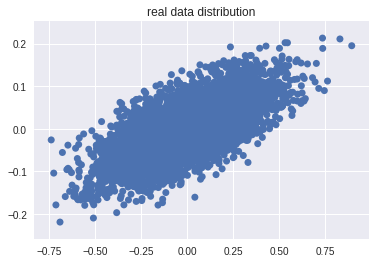

In [3]:
# create n_samples sampled from Gaussian distribution
n_samples = 5000

cov_mat = 0.01 * np.eye(2) + [[0., 0.0], [0.05, 0.]]
print("real data cov matrix: \n", cov_mat)
pdf_x = np.random.multivariate_normal(np.zeros(2), cov_mat, n_samples)
# print "pdf shape: ", pdf_x.shape
_ = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], edgecolor='none')
_ = plt.title('real data distribution')

# Problem

### We want to build a GAN that learns a mapping:

#### uniform distribution `Z` in [-1, 1] --> Pdata distribution of `5000` samples.

### We can do so with the following networks Generator and Discriminator:

```
Generator (
  (fc1): Linear (50 -> 256)
  (fc2): Linear (256 -> 256)
  (out_fc): Linear (256 -> 2)
)
```

```
Discriminator (
  (fc1): Linear (2 -> 128)
  (fc2): Linear (128 -> 128)
  (out_fc): Linear (128 -> 1)
)
```

### Exercise 1

Build a Generator network with PyTorch tools following the definition provided in the problem statement.

In [0]:
class Generator(nn.Module):
    """ This network maps z (withdrawn from prior distribution) to the pdf in train data with dim `out_dim` """
    def __init__(self, z_dim=100, out_dim=2, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out_fc = nn.Linear(hidden_size, out_dim)
    
    def forward(self, x):
        h1 = F.leaky_relu(self.fc1(x), 0.3)
        h2 = F.leaky_relu(self.fc2(h1), 0.3)
        h3 = self.out_fc(h2)
        return h3

### Exercise 2

Build a Discriminator network with PyTorch tools following the definition provided in the problem statement. Implement the forward section of the Discriminator (based on Generator but with proper changes).

In [0]:
class Discriminator(nn.Module):
    """ This network classifies its input as either real or fake """
    def __init__(self, input_dim=2, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [0]:
# Optional weight init scheme different than that by default in Linear layers
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1.4)

### Exercise 3

Fill in the blank of next code, specifying the loss required to perform a real/fake binary classification in the output of D network. Also, make sure you understand why we have 2 optimizers `g_opt` and `d_opt` before proceeding with training.

In [7]:
# Hyperparams
# TTUR learning rate schedule (check: https://arxiv.org/pdf/1805.08318.pdf)
# TTUR makes us not depend on D_UPDATES (so converging faster, 1 update of D
# per update of G), and still makes D learn faster with a higher lr than G, so
# optimizing quicker to find better features, such that G learns about a better
# reality too.
G_LR = 0.0001
D_LR = 0.0004
Z_DIM = 50
BATCH_SIZE = 100
N_EPOCHS = 28
VIZ_EVERY = 100
D_UPDATES = 1

# Create both networks
g_net = Generator(z_dim=Z_DIM, hidden_size=256)
#g_net.apply(weights_init)
d_net = Discriminator()
#d_net.apply(weights_init)

print(g_net)
print(d_net)

# Loss is Binary CrossEntropy
criterion = nn.BCELoss()

# Create the two optimizers
g_opt = optim.Adam(g_net.parameters(), lr=G_LR, betas=(0.5, 0.999))
d_opt = optim.Adam(d_net.parameters(), lr=D_LR, betas=(0.5, 0.999))

Generator(
  (fc1): Linear(in_features=50, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out_fc): Linear(in_features=256, out_features=2, bias=True)
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.3, inplace)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.3, inplace)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### Exercise 4

Make the update routine of network G (you should have a look at update routine of network D and map it into G, with proper changes).

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


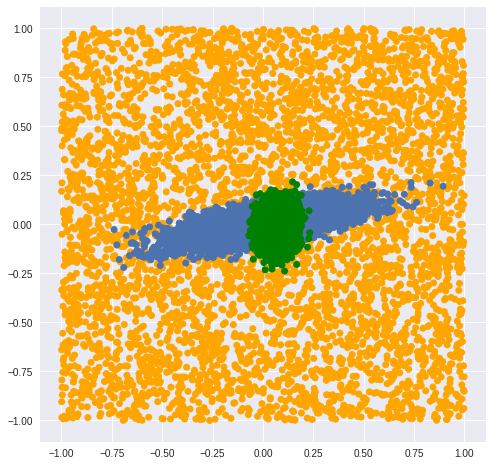

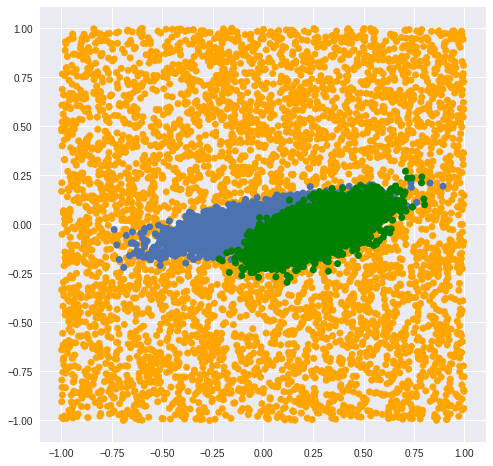

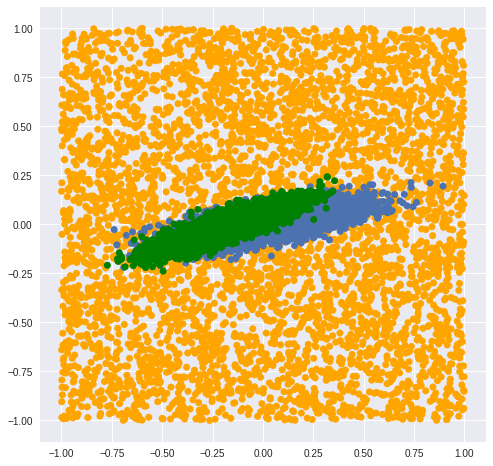

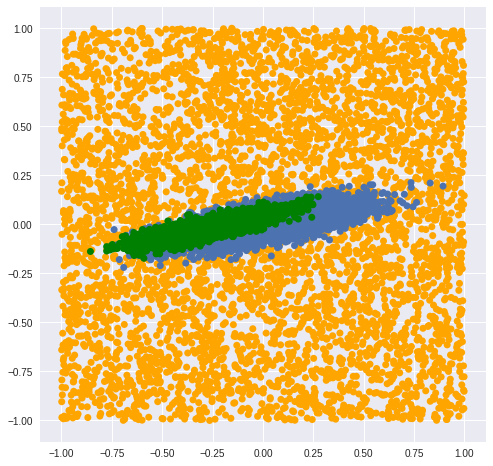

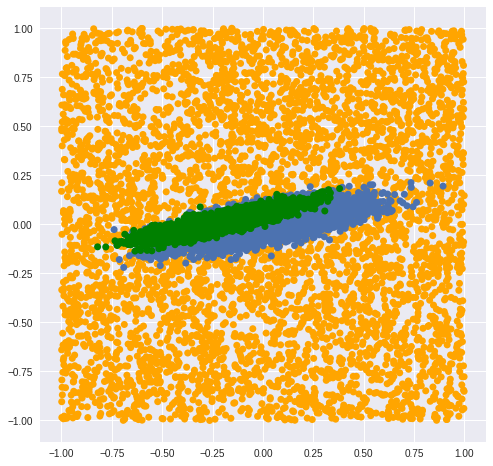

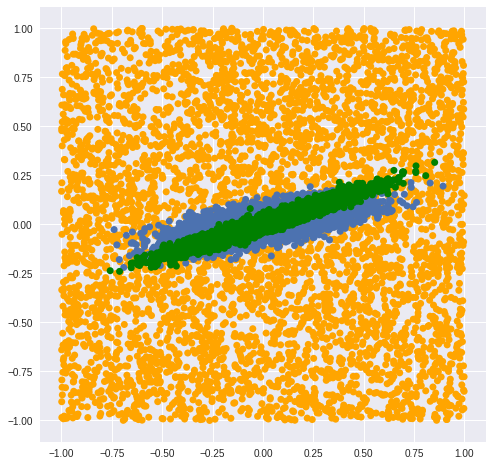

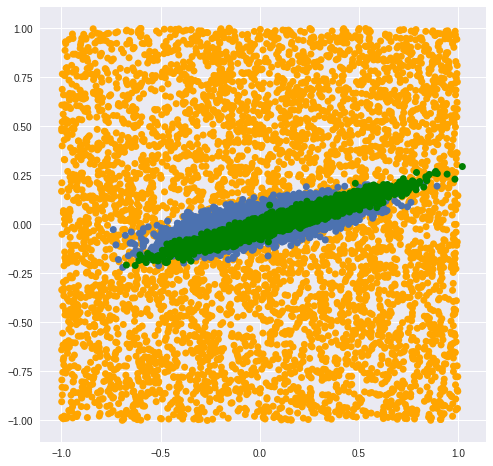

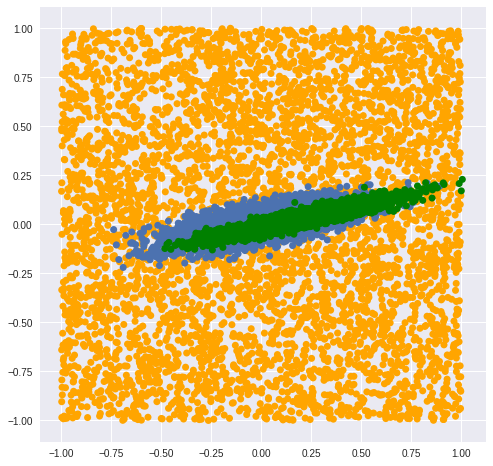

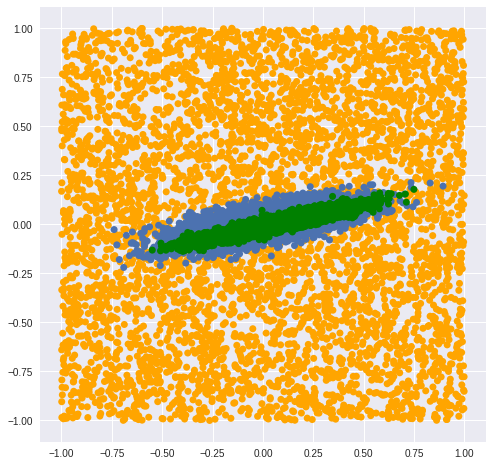

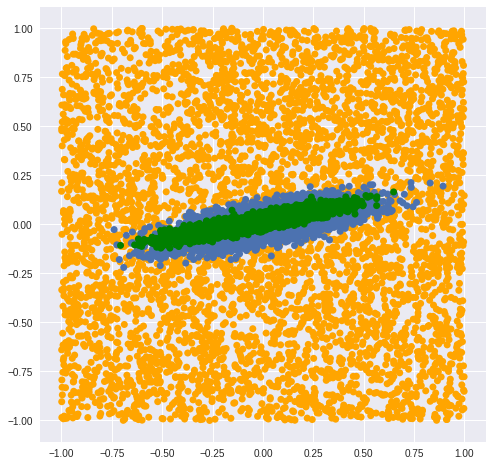

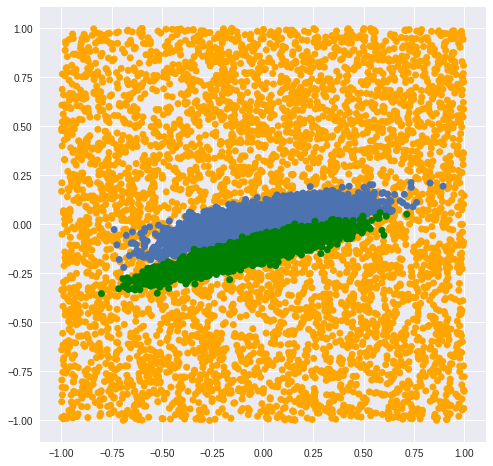

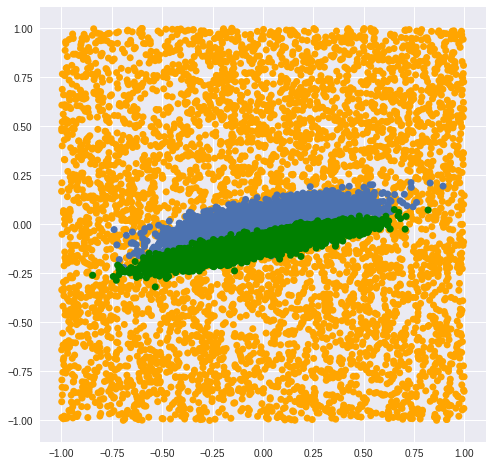

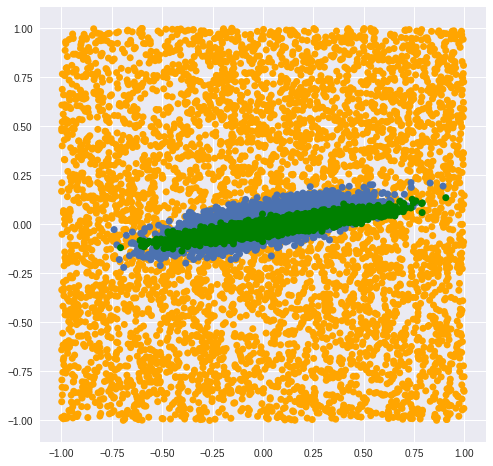

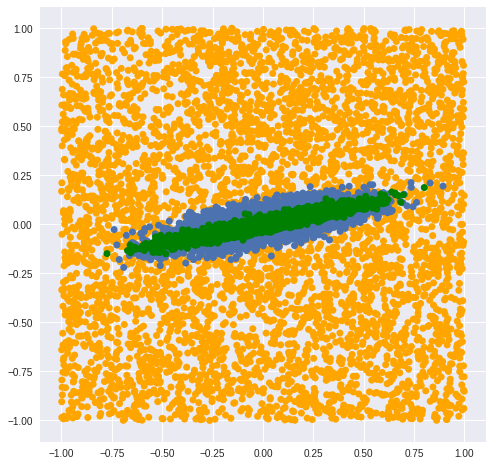

Done training for 28 epochs! Elapsed time: 10.448300887999721 s
Total amount of iterations done:  1399


In [8]:
# store resulting losses out of training
d_rl_losses = []
d_fk_losses = []
d_losses = []
g_losses = []

# Pick a big sample from z and project it through G and compare to pdf_x (original data pdf)
# this is not data to be trained on, but to check G projections
sample_z = np.random.uniform(-1, 1, [n_samples, Z_DIM]).astype(np.float32)
# OPT. EXERCISE: NOTE THE requires_grad=False. WHAT IS IT DOING?
v_sample_z = torch.FloatTensor(sample_z)
v_sample_z.requires_grad=False
batches_per_epoch = pdf_x.shape[0] / BATCH_SIZE
counter = 0
curr_epoch = -1
batch_timings = []

for counter in range(int(N_EPOCHS * batches_per_epoch)):
    if counter % batches_per_epoch == 0:
        # epoch change. First time this if is true, so also init variables.
        batch_idx = 0
        curr_epoch += 1
        # randomize the pdf_x samples
        np.random.shuffle(pdf_x)
    beg_t = timeit.default_timer()
    # sample a batch from prior pdf z
    batch_z = torch.FloatTensor(np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32))
    # get a batch of samples from gtruth pdf
    batch_x_real = torch.FloatTensor(pdf_x[batch_idx:(batch_idx + BATCH_SIZE)])
    # reset gradients in both optimizers (set grad matrices to zero)
    d_opt.zero_grad()
    g_opt.zero_grad()
    # ------------ DISCRIMINATOR TRAINING
    # build real label
    for d_i in range(D_UPDATES):
        d_opt.zero_grad()
        labv = torch.ones(batch_x_real.size(0))
        # (1) REAL D LOSS
        d_real = d_net(batch_x_real)
        d_real_loss = criterion(d_real, labv)
        d_real_loss.backward()

        # (2) FAKE D LOSS
        batch_x_fake = g_net(batch_z)
        # OPT. EXERCISE: NOTE THE DETACH. WHAT IS IT DOING?
        d_fake = d_net(batch_x_fake.detach())
        # build fake label
        labv.data.fill_(0.)
        d_fake_loss = criterion(d_fake, labv)
        d_fake_loss.backward()
        d_opt.step()
    
    d_loss = d_fake_loss + d_real_loss
    # ------------ GENERATOR TRAINING
    # (1) build real label `labv`
    labv = torch.ones(batch_z.size(0))
    # (2) forward the z batch through G
    batch_x_fake = g_net(batch_z)
    # (3) compute the G real loss with the label Variable
    g_real = d_net(batch_x_fake)
    g_real_loss = criterion(g_real, labv)
    # (4) backprop gradients
    g_real_loss.backward()
    # (5) update network parameters
    g_opt.step()
    # Gather losses to print later
    d_fk_losses.append(d_fake_loss.data.numpy())
    d_rl_losses.append(d_real_loss.data.numpy())
    d_losses.append(d_loss.data.numpy())
    g_losses.append(g_real_loss.data.numpy())
    
    end_t = timeit.default_timer()
    batch_timings.append(end_t - beg_t)
    
    if counter % VIZ_EVERY == 0:
        fig = plt.figure(figsize=(8, 8))
        fake_pred = g_net(v_sample_z).data.numpy()
        _ = plt.scatter(sample_z[:, 0], sample_z[:, 1], edgecolor='none', color='orange')
        _ = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], edgecolor='none')
        _ = plt.scatter(fake_pred[:, 0], fake_pred[:, 1], color='green', edgecolor='none')
        plt.show()
print("Done training for {} epochs! Elapsed time: {} s".format(N_EPOCHS, np.sum(batch_timings)))
print("Total amount of iterations done: ", counter)
    

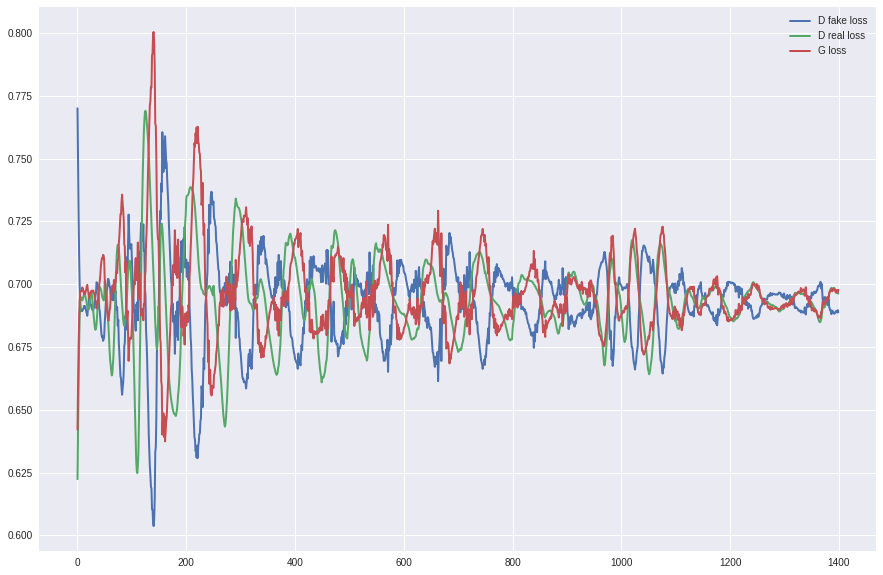

In [9]:
# Visualize the learning curves (let's see the funny behavior of GANs in action!)
_= plt.figure(figsize=(15, 10))
_ = plt.plot(d_fk_losses, label='D fake loss', linewidth=2.)
_ = plt.plot(d_rl_losses, label='D real loss', linewidth=2.)
#plt.plot(d_losses, label='D loss')
_ = plt.plot(g_losses, label='G loss', linewidth=2.)
_ = plt.legend()
# NOTE: there is no optimization towards a minima! Instead they are very noisy and paired to each other! 
# They have to be balanced through the training stage.

### Exercise 5

Sample a batch of `z` samples and make G infer `G(z)`, placing the result in variable `g_pred` to plot it.

Inferred 5000 G samples in 0.06928157799984547 s


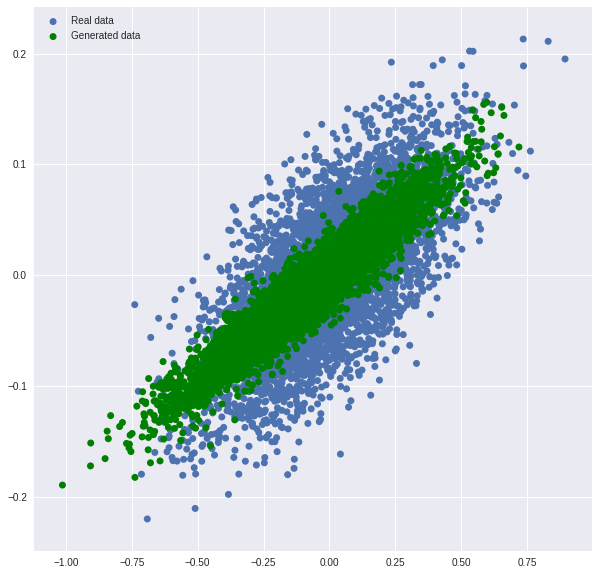

In [10]:
beg_t = timeit.default_timer()
# sample new z vectors from prior
batch_z = np.random.uniform(-1, 1, [n_samples, Z_DIM]).astype(np.float32)
batch_z = torch.tensor(batch_z)
# forward through G
g_pred = g_net(batch_z)
g_pred = g_pred.data.numpy()
end_t = timeit.default_timer()
print("Inferred {} G samples in {} s".format(n_samples, end_t - beg_t))
_ = plt.figure(figsize=(10, 10))
#_ = plt.scatter(sample_z[:, 0], sample_z[:, 1], color='orange', label='Prior z', edgecolor='none')
_ = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], label='Real data', edgecolor='none')
_ = plt.scatter(g_pred[:, 0], g_pred[:, 1], color='green', label='Generated data', edgecolor='none')
_ = plt.legend()